In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


In [2]:
def show_tensor_image(tensor):  # 텐서 순서를 (C, H, W)에서 (H, W, C)로 변경하고 numpy array로 변환
    image = tensor.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [3]:
def val_plot(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Training and Test Loss')

    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(test_accuracies, label='Test Accuracy')  # , color='orange'
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].set_title('Training and Test Accuracy')

    plt.tight_layout()
    plt.show()

In [4]:
def cuda_message():
    if torch.cuda.is_available():
        print("CUDA(GPU)를 사용합니다.")
    else:
        print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

cuda_message()

CUDA(GPU)를 사용합니다.


In [6]:
# myResNet 클래스 정의
class myResNet(nn.Module):
    def __init__(self, model_num=18, num_classes=2):
        super(myResNet, self).__init__()

        if model_num == 18:
            self.resnet = models.resnet18(weights=None)
        elif model_num == 34:
            self.resnet = models.resnet34(weights=None)
        elif model_num == 50:
            self.resnet = models.resnet50(weights=None)
        elif model_num == 101:
            self.resnet = models.resnet101(weights=None)
        elif model_num == 152:
            self.resnet = models.resnet152(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [7]:
# myVGG 클래스 정의
class myVGG(nn.Module):
    def __init__(self, model_kind="16", num_classes=2):
        super(myVGG, self).__init__()

        if model_kind == "11":
            self.vgg = models.vgg11(weights=None)
        elif model_kind == "11_bn":
            self.vgg = models.vgg11_bn(weights=None)
        elif model_kind == "13":
            self.vgg = models.vgg13(weights=None)
        elif model_kind == "13_bn":
            self.vgg = models.vgg13_bn(weights=None)
        elif model_kind == "16":
            self.vgg = models.vgg16(weights=None)
        elif model_kind == "16_bn":
            self.vgg = models.vgg16_bn(weights=None)
        elif model_kind == "19":
            self.vgg = models.vgg19(weights=None)
        elif model_kind == "19_bn":
            self.vgg = models.vgg19_bn(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vgg.classifier[6].in_features  # classifier["6"] -> 6, vgg에서 정해진 수?
        self.vgg.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.vgg(x)

In [8]:
# myLeNet 클래스 정의
class myLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(myLeNet, self).__init__()
        self.lenet = models.googlenet(weights=None)

        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.lenet.fc.in_features
        self.lenet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.lenet(x)

In [9]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()  # 어차피 train에선 test와 달리 loss.backward() 해야하기 때문에 loss 따로 객체화
        loss.backward()
        optimizer.step()
    # 예측값 계산 (가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)  # output.argmax(dim=1, keepdim=True)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()  # pred.eq(target.view_as(pred)).sum().item()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [10]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # .view_as(): View this tensor as the same size as other. self.view_as(other) is equivalent to self.view(other.size())
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [11]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()
    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [12]:
# import shutil
# shutil.rmtree('C:/Users/bgmbg/Downloads/face_age/.ipynb_checkpoints')

In [13]:
trans_origin = transforms.Compose(
    [
        # transforms.CenterCrop((500, 500)),  # norm 계산 여부
        transforms.ToTensor(),
    ]
)

# 아래 수정/출력 요망

# full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
# test_dataset_origin = ImageFolder('IMAGE/Covid19-dataset/test', transform=trans_origin)
# test_loader_origin = torch.utils.data.DataLoader(test_dataset_origin, batch_size=64, shuffle=False)

# original_images, _ = next(iter(test_loader_origin))
# transform_images, _ = next(iter(test_loader))

# fig, axes = plt.subplots(3, 3)
# fig.set_size_inches(4, 6)

# for idx in range(3):
#     axes[idx, 0].imshow(original_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 0].set_axis_off()
#     axes[idx, 0].set_title('Original (200,200)')
#     axes[idx, 1].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 1].set_axis_off()
#     axes[idx, 1].set_title('Resized (100,100)')
#     axes[idx, 2].imshow(transform_images[idx].permute(1, 2, 0), cmap='gray')
#     axes[idx, 2].set_axis_off()
#     axes[idx, 2].set_title('Resized (50,50)')
# fig.tight_layout()
# plt.show()

In [14]:
torch.manual_seed(42)

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    # transforms.Resize((100, 100)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize((0.6360717, 0.4874842, 0.41885874),
                         (0.21104145, 0.18984404, 0.18253866))  # 이미지를 -1에서 1로 정규화
])
# 데이터셋 로드
full_dataset = datasets.ImageFolder(root='./face_age', transform=transform)
print(full_dataset)
count = Counter(full_dataset.targets)
print(count)

# 데이터를 훈련셋과 테스트셋으로 랜덤으로 분할
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

cnt = []
for i in range(train_size):  # 
    cnt.append(train_dataset[i][1])
print(Counter(cnt))
# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 9778
    Root location: ./face_age
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.6360717, 0.4874842, 0.41885874), std=(0.21104145, 0.18984404, 0.18253866))
           )
Counter({0: 1112, 6: 856, 17: 794, 4: 759, 5: 661, 3: 554, 8: 554, 9: 554, 12: 539, 16: 521, 7: 480, 13: 399, 11: 371, 2: 355, 14: 339, 15: 317, 1: 309, 10: 304})
Counter({0: 898, 6: 687, 17: 630, 4: 612, 5: 536, 3: 449, 8: 438, 9: 433, 12: 428, 16: 423, 7: 388, 13: 312, 11: 296, 2: 286, 14: 275, 15: 247, 1: 242, 10: 242})


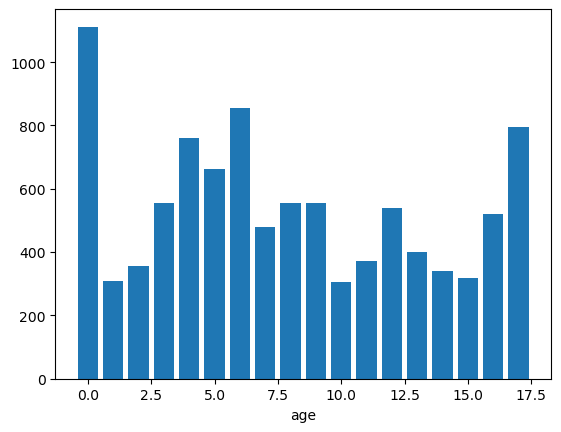

In [15]:
# 인덱스, 눈금 수정 요망
# age_sorted = ['1', '2-3', '4-6', '7-9', '10-12',
#               '13-15', '16-19', '20-24', '25-29', '30-34',
#               '35-39', '40-44', '45-49', '50-54', '55-59',
#               '60-64', '65-69', '70']
# age_dict = {'1': 0, '10-12': 1, '13-15': 2, '16-19': 3, '2-3': 4,
#             '20-24': 5, '25-29': 6, '30-34': 7, '35-39': 8, '4-6': 9,
#             '40-44': 10, '45-49': 11, '50-54': 12, '55-59': 13, '60-64': 14,
#             '65-69': 15, '7-9': 16, '70': 17}

age_list = list(count.keys())
frequencies = list(count.values())

plt.bar(age_list, frequencies)
plt.xlabel('age')
plt.show()

In [16]:
### 1. resnet18
### 1-1. resnet18 / SGD
### 1-2. resnet18 / RMSprop
### 1-3. resnet18 / AdamW
### 2. vgg13
### 3. googlenet

### 1-1-1. resnet18 / SGD(lr=0.010, mo=0.9)

In [20]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.9)

In [21]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [22]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4217, Accuracy: 50.00%
Test loss: 2.1077, Accuracy: 28.83%
Epoch 2, Training loss: 2.0021, Accuracy: 7.14%
Test loss: 2.1009, Accuracy: 31.90%
Epoch 3, Training loss: 1.7937, Accuracy: 35.71%
Test loss: 1.9105, Accuracy: 32.00%
Epoch 4, Training loss: 1.5694, Accuracy: 42.86%
Test loss: 2.0938, Accuracy: 31.13%
Epoch 5, Training loss: 1.3857, Accuracy: 35.71%
Test loss: 2.0984, Accuracy: 33.95%
Epoch 6, Training loss: 1.2254, Accuracy: 42.86%
Test loss: 2.2136, Accuracy: 30.88%
Epoch 7, Training loss: 1.0544, Accuracy: 64.29%
Test loss: 2.2757, Accuracy: 33.03%
Epoch 8, Training loss: 0.8198, Accuracy: 71.43%
Test loss: 2.6196, Accuracy: 32.36%
Epoch 9, Training loss: 0.6394, Accuracy: 64.29%
Test loss: 2.7617, Accuracy: 32.57%
Epoch 10, Training loss: 0.5219, Accuracy: 71.43%
Test loss: 3.3485, Accuracy: 31.44%
Epoch 11, Training loss: 0.4258, Accuracy: 78.57%
Test loss: 3.2869, Accuracy: 32.72%
Epoch 12, Training loss: 0.3270, Accuracy: 78.57%
Test loss: 3.1

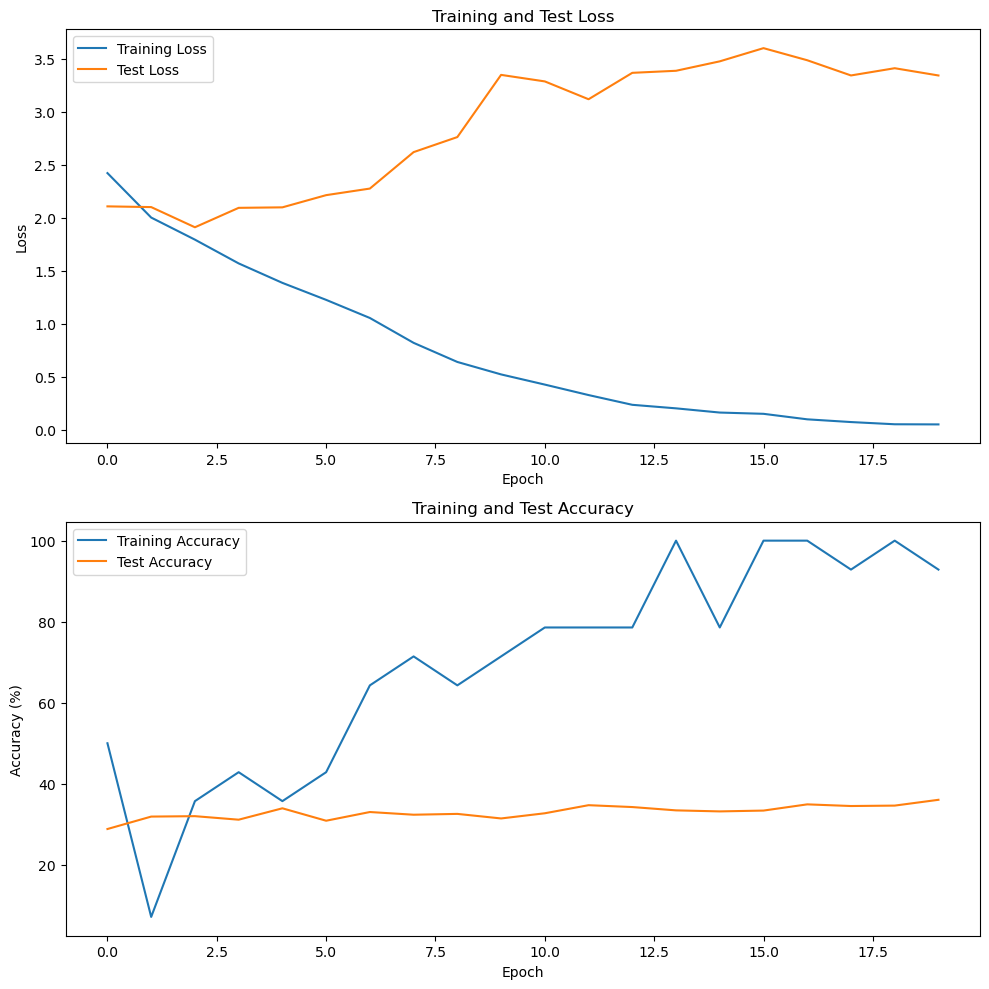

In [23]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-2. resnet18 / SGD(lr=0.010, mo=0.5)

In [24]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.5)

In [25]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [26]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.5177, Accuracy: 14.29%
Test loss: 2.3011, Accuracy: 21.42%
Epoch 2, Training loss: 2.0808, Accuracy: 21.43%
Test loss: 2.1118, Accuracy: 28.68%
Epoch 3, Training loss: 1.8445, Accuracy: 21.43%
Test loss: 2.1443, Accuracy: 22.55%
Epoch 4, Training loss: 1.6113, Accuracy: 28.57%
Test loss: 1.9844, Accuracy: 31.44%
Epoch 5, Training loss: 1.3750, Accuracy: 28.57%
Test loss: 1.9267, Accuracy: 33.18%
Epoch 6, Training loss: 1.0954, Accuracy: 57.14%
Test loss: 2.0881, Accuracy: 31.39%
Epoch 7, Training loss: 0.8317, Accuracy: 28.57%
Test loss: 2.3813, Accuracy: 28.17%
Epoch 8, Training loss: 0.5799, Accuracy: 92.86%
Test loss: 2.2922, Accuracy: 30.01%
Epoch 9, Training loss: 0.3536, Accuracy: 92.86%
Test loss: 2.5043, Accuracy: 29.65%
Epoch 10, Training loss: 0.2065, Accuracy: 100.00%
Test loss: 2.4867, Accuracy: 31.95%
Epoch 11, Training loss: 0.1359, Accuracy: 71.43%
Test loss: 2.7914, Accuracy: 29.75%
Epoch 12, Training loss: 0.1427, Accuracy: 100.00%
Test loss: 

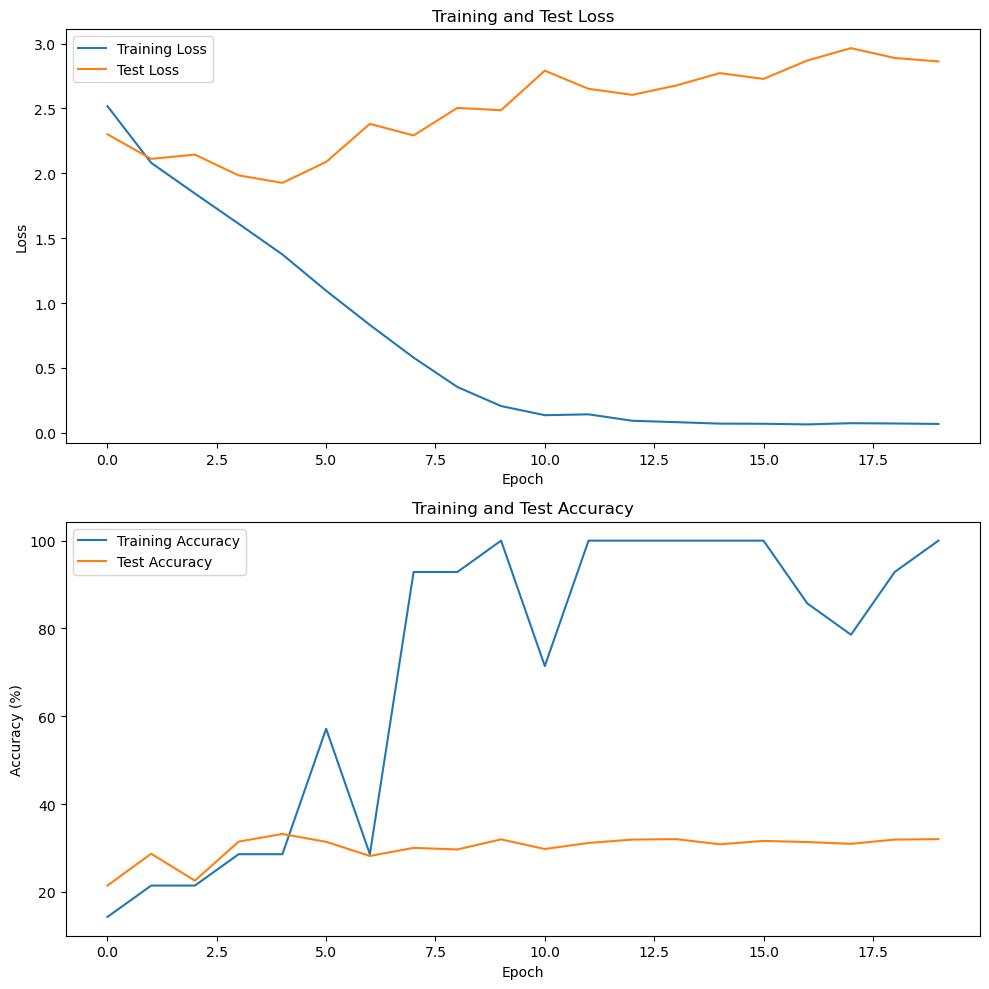

In [27]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-3. resnet18 / SGD(lr=0.010, mo=0.25)

In [28]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.010, momentum=0.25)

In [29]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [30]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.5638, Accuracy: 14.29%
Test loss: 2.4110, Accuracy: 20.45%
Epoch 2, Training loss: 2.1734, Accuracy: 42.86%
Test loss: 2.1859, Accuracy: 26.33%
Epoch 3, Training loss: 1.9471, Accuracy: 28.57%
Test loss: 2.0746, Accuracy: 28.58%
Epoch 4, Training loss: 1.7380, Accuracy: 28.57%
Test loss: 2.2069, Accuracy: 24.23%
Epoch 5, Training loss: 1.5128, Accuracy: 42.86%
Test loss: 2.0338, Accuracy: 29.45%
Epoch 6, Training loss: 1.2773, Accuracy: 57.14%
Test loss: 1.9567, Accuracy: 31.70%
Epoch 7, Training loss: 1.0192, Accuracy: 85.71%
Test loss: 2.0148, Accuracy: 32.67%
Epoch 8, Training loss: 0.7638, Accuracy: 57.14%
Test loss: 2.3478, Accuracy: 31.54%
Epoch 9, Training loss: 0.5406, Accuracy: 100.00%
Test loss: 2.2566, Accuracy: 31.39%
Epoch 10, Training loss: 0.3291, Accuracy: 78.57%
Test loss: 2.7533, Accuracy: 25.31%
Epoch 11, Training loss: 0.2387, Accuracy: 71.43%
Test loss: 2.5145, Accuracy: 31.19%
Epoch 12, Training loss: 0.1745, Accuracy: 100.00%
Test loss: 

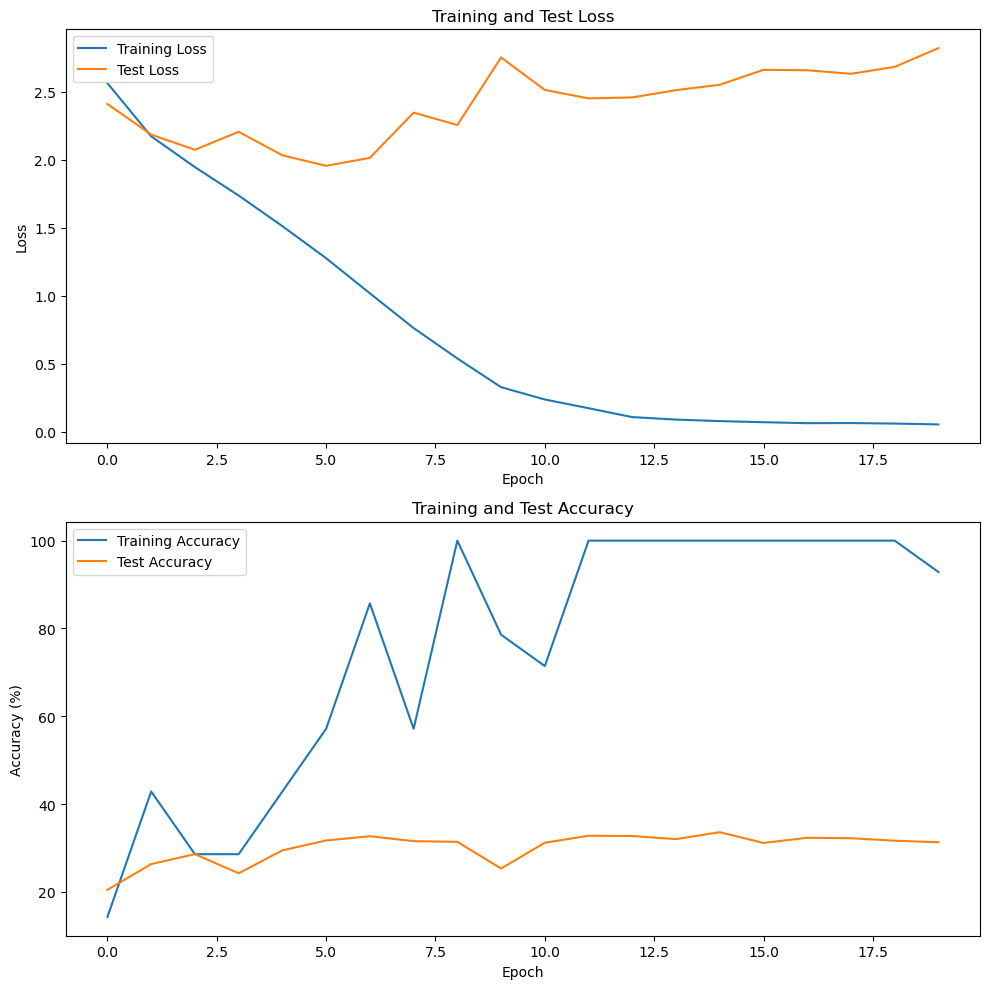

In [31]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-4. resnet18 / SGD(lr=0.005, mo=0.9)

In [32]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [33]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [34]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.4368, Accuracy: 14.29%
Test loss: 2.2674, Accuracy: 25.15%
Epoch 2, Training loss: 2.0096, Accuracy: 28.57%
Test loss: 2.0760, Accuracy: 29.65%
Epoch 3, Training loss: 1.7870, Accuracy: 35.71%
Test loss: 1.9627, Accuracy: 32.36%
Epoch 4, Training loss: 1.5867, Accuracy: 21.43%
Test loss: 2.0627, Accuracy: 31.54%
Epoch 5, Training loss: 1.3491, Accuracy: 50.00%
Test loss: 2.0234, Accuracy: 32.16%
Epoch 6, Training loss: 1.1107, Accuracy: 57.14%
Test loss: 2.2848, Accuracy: 30.21%
Epoch 7, Training loss: 0.8552, Accuracy: 71.43%
Test loss: 2.4076, Accuracy: 31.70%
Epoch 8, Training loss: 0.6361, Accuracy: 57.14%
Test loss: 2.6451, Accuracy: 31.49%
Epoch 9, Training loss: 0.5140, Accuracy: 71.43%
Test loss: 2.9486, Accuracy: 28.37%
Epoch 10, Training loss: 0.3959, Accuracy: 57.14%
Test loss: 3.0634, Accuracy: 30.42%
Epoch 11, Training loss: 0.3478, Accuracy: 92.86%
Test loss: 3.0367, Accuracy: 31.85%
Epoch 12, Training loss: 0.2204, Accuracy: 85.71%
Test loss: 3.

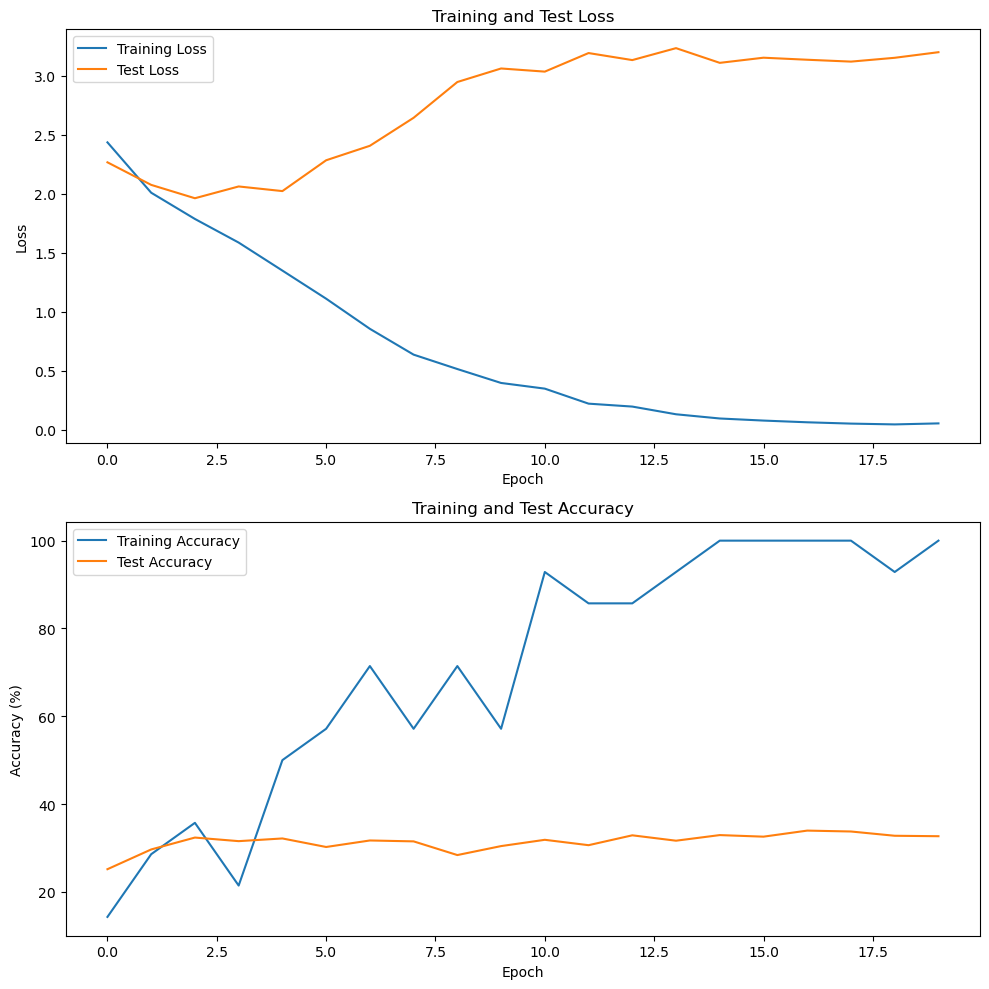

In [35]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-5. resnet18 / SGD(lr=0.005, mo=0.5)

In [36]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.5)

In [37]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [38]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.5985, Accuracy: 14.29%
Test loss: 2.4172, Accuracy: 21.73%
Epoch 2, Training loss: 2.2064, Accuracy: 28.57%
Test loss: 2.1955, Accuracy: 27.15%
Epoch 3, Training loss: 1.9829, Accuracy: 50.00%
Test loss: 2.0789, Accuracy: 29.29%
Epoch 4, Training loss: 1.7891, Accuracy: 28.57%
Test loss: 2.0163, Accuracy: 29.29%
Epoch 5, Training loss: 1.5968, Accuracy: 21.43%
Test loss: 1.9881, Accuracy: 29.91%
Epoch 6, Training loss: 1.3870, Accuracy: 57.14%
Test loss: 1.9935, Accuracy: 31.65%
Epoch 7, Training loss: 1.1765, Accuracy: 35.71%
Test loss: 1.9856, Accuracy: 30.98%
Epoch 8, Training loss: 0.9561, Accuracy: 64.29%
Test loss: 2.0045, Accuracy: 31.95%
Epoch 9, Training loss: 0.7234, Accuracy: 50.00%
Test loss: 2.0434, Accuracy: 33.03%
Epoch 10, Training loss: 0.5259, Accuracy: 92.86%
Test loss: 2.1657, Accuracy: 31.44%
Epoch 11, Training loss: 0.3565, Accuracy: 85.71%
Test loss: 2.3475, Accuracy: 27.71%
Epoch 12, Training loss: 0.2445, Accuracy: 92.86%
Test loss: 2.

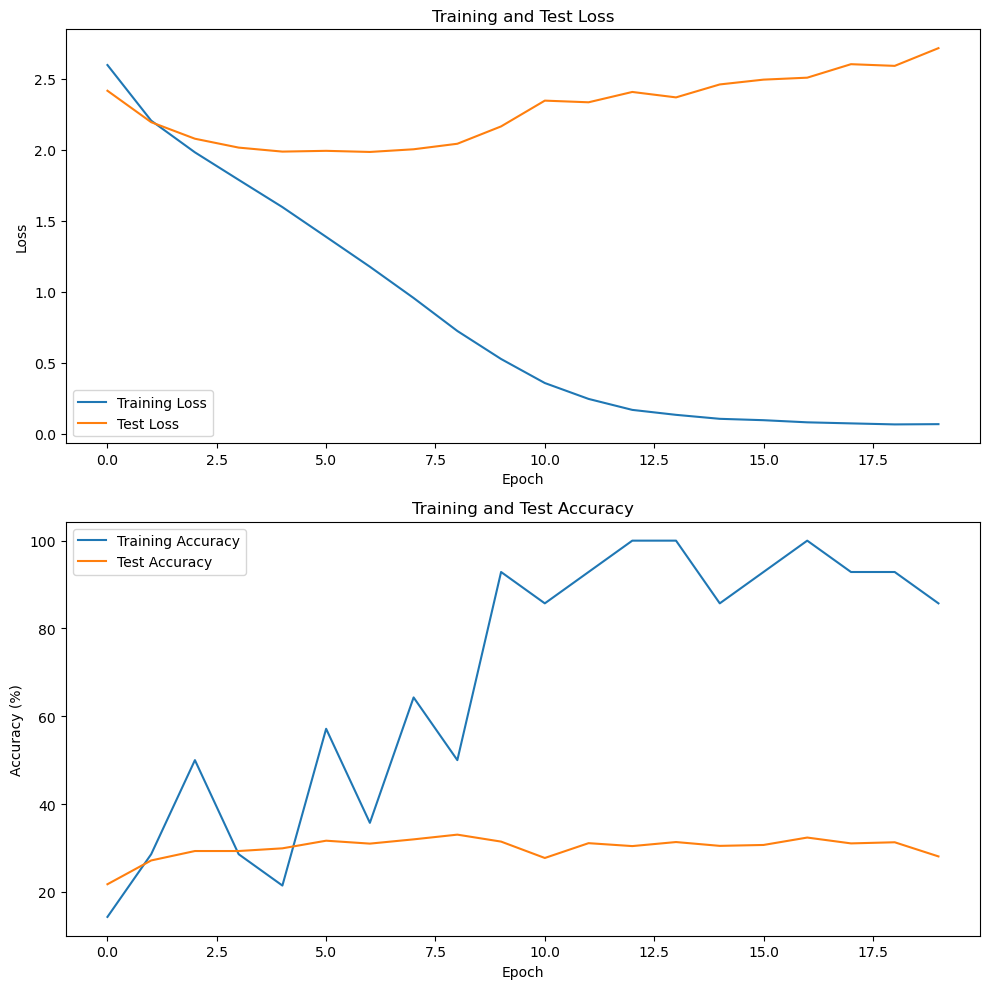

In [39]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-6. resnet18 / SGD(lr=0.005, mo=0.25)

In [40]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.25)

In [41]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [42]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6756, Accuracy: 7.14%
Test loss: 2.5364, Accuracy: 19.43%
Epoch 2, Training loss: 2.3496, Accuracy: 28.57%
Test loss: 2.3051, Accuracy: 24.85%
Epoch 3, Training loss: 2.1327, Accuracy: 14.29%
Test loss: 2.2005, Accuracy: 26.94%
Epoch 4, Training loss: 1.9551, Accuracy: 35.71%
Test loss: 2.1149, Accuracy: 27.10%
Epoch 5, Training loss: 1.7926, Accuracy: 50.00%
Test loss: 2.0563, Accuracy: 27.66%
Epoch 6, Training loss: 1.6440, Accuracy: 42.86%
Test loss: 2.0030, Accuracy: 31.03%
Epoch 7, Training loss: 1.4939, Accuracy: 21.43%
Test loss: 2.0046, Accuracy: 30.42%
Epoch 8, Training loss: 1.3313, Accuracy: 78.57%
Test loss: 1.9770, Accuracy: 30.83%
Epoch 9, Training loss: 1.1521, Accuracy: 50.00%
Test loss: 1.9613, Accuracy: 32.11%
Epoch 10, Training loss: 0.9684, Accuracy: 78.57%
Test loss: 1.9941, Accuracy: 31.29%
Epoch 11, Training loss: 0.7971, Accuracy: 71.43%
Test loss: 2.0155, Accuracy: 31.03%
Epoch 12, Training loss: 0.6423, Accuracy: 71.43%
Test loss: 2.0

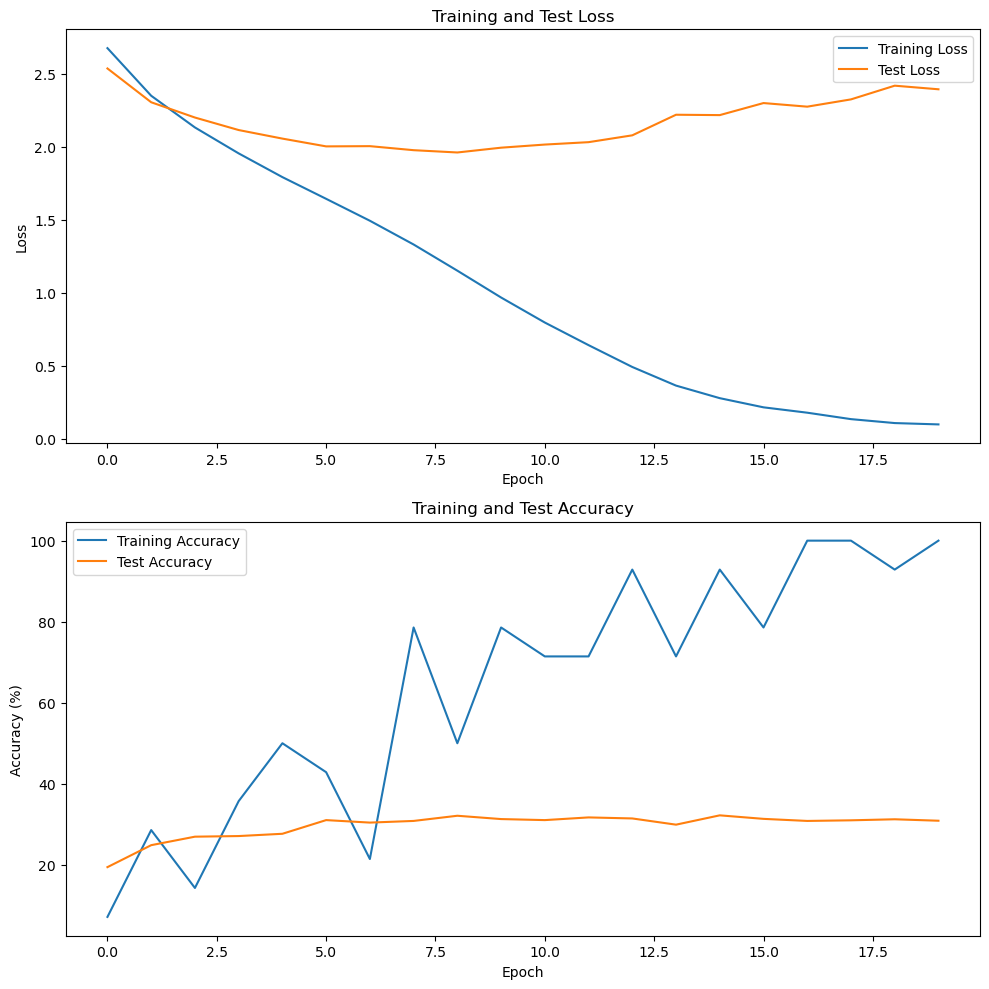

In [43]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-7. resnet18 / SGD(lr=0.001, mo=0.9)

In [45]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [46]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [47]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6245, Accuracy: 42.86%
Test loss: 2.4186, Accuracy: 23.57%
Epoch 2, Training loss: 2.2390, Accuracy: 42.86%
Test loss: 2.1966, Accuracy: 27.25%
Epoch 3, Training loss: 2.0047, Accuracy: 50.00%
Test loss: 2.0704, Accuracy: 29.45%
Epoch 4, Training loss: 1.8191, Accuracy: 42.86%
Test loss: 1.9956, Accuracy: 31.75%
Epoch 5, Training loss: 1.6353, Accuracy: 35.71%
Test loss: 1.9632, Accuracy: 30.78%
Epoch 6, Training loss: 1.4372, Accuracy: 42.86%
Test loss: 1.9436, Accuracy: 32.26%
Epoch 7, Training loss: 1.2242, Accuracy: 57.14%
Test loss: 1.9460, Accuracy: 32.77%
Epoch 8, Training loss: 1.0006, Accuracy: 64.29%
Test loss: 1.9669, Accuracy: 33.59%
Epoch 9, Training loss: 0.7803, Accuracy: 64.29%
Test loss: 2.0262, Accuracy: 32.06%
Epoch 10, Training loss: 0.5849, Accuracy: 71.43%
Test loss: 2.0571, Accuracy: 33.03%
Epoch 11, Training loss: 0.3965, Accuracy: 100.00%
Test loss: 2.1437, Accuracy: 32.62%
Epoch 12, Training loss: 0.2748, Accuracy: 85.71%
Test loss: 2

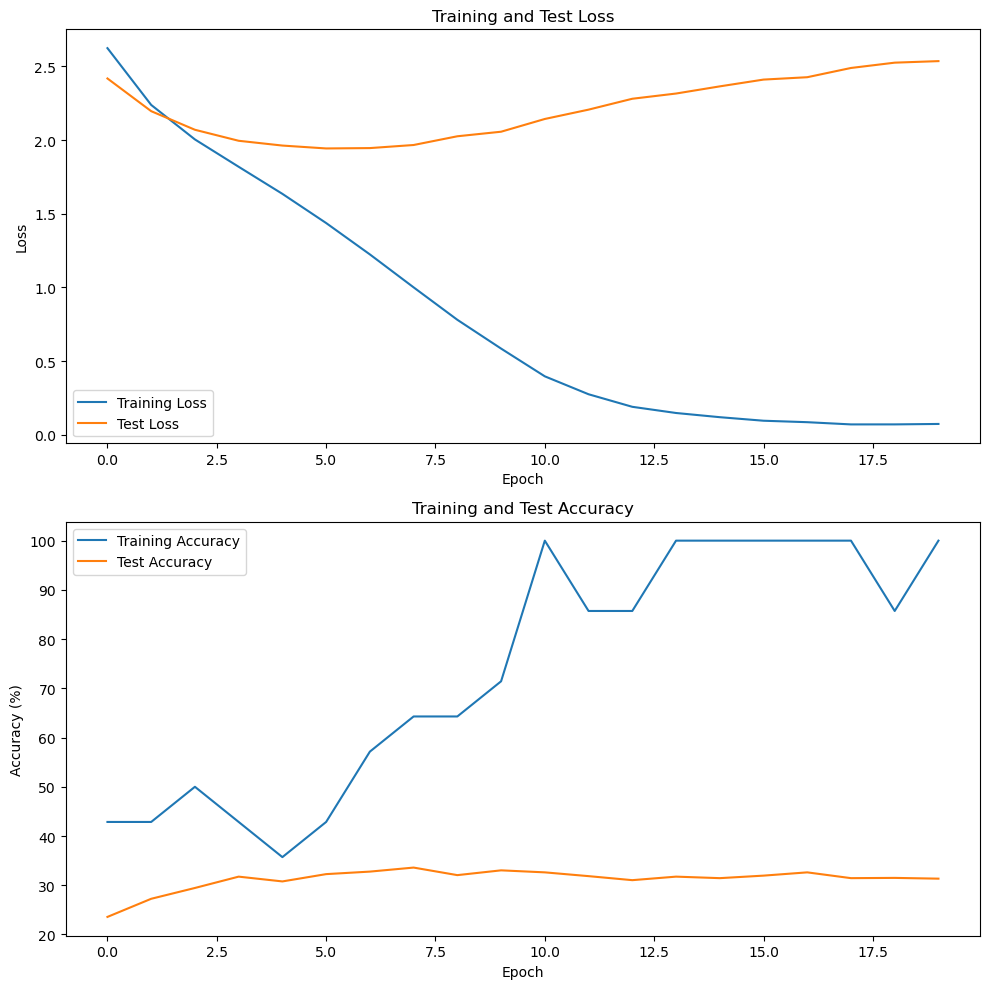

In [48]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-8. resnet18 / SGD(lr=0.001, mo=0.5)

In [17]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [18]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [19]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.7730, Accuracy: 14.29%
Test loss: 2.7023, Accuracy: 17.23%
Epoch 2, Training loss: 2.5958, Accuracy: 14.29%
Test loss: 2.5657, Accuracy: 21.11%
Epoch 3, Training loss: 2.4568, Accuracy: 35.71%
Test loss: 2.4638, Accuracy: 22.65%
Epoch 4, Training loss: 2.3354, Accuracy: 28.57%
Test loss: 2.3855, Accuracy: 25.05%
Epoch 5, Training loss: 2.2307, Accuracy: 57.14%
Test loss: 2.3034, Accuracy: 25.87%
Epoch 6, Training loss: 2.1419, Accuracy: 14.29%
Test loss: 2.2454, Accuracy: 27.76%
Epoch 7, Training loss: 2.0613, Accuracy: 50.00%
Test loss: 2.2088, Accuracy: 27.71%
Epoch 8, Training loss: 1.9913, Accuracy: 35.71%
Test loss: 2.1729, Accuracy: 28.22%
Epoch 9, Training loss: 1.9189, Accuracy: 28.57%
Test loss: 2.1337, Accuracy: 28.27%
Epoch 10, Training loss: 1.8503, Accuracy: 42.86%
Test loss: 2.1052, Accuracy: 30.01%
Epoch 11, Training loss: 1.7844, Accuracy: 35.71%
Test loss: 2.0834, Accuracy: 29.96%
Epoch 12, Training loss: 1.7200, Accuracy: 28.57%
Test loss: 2.

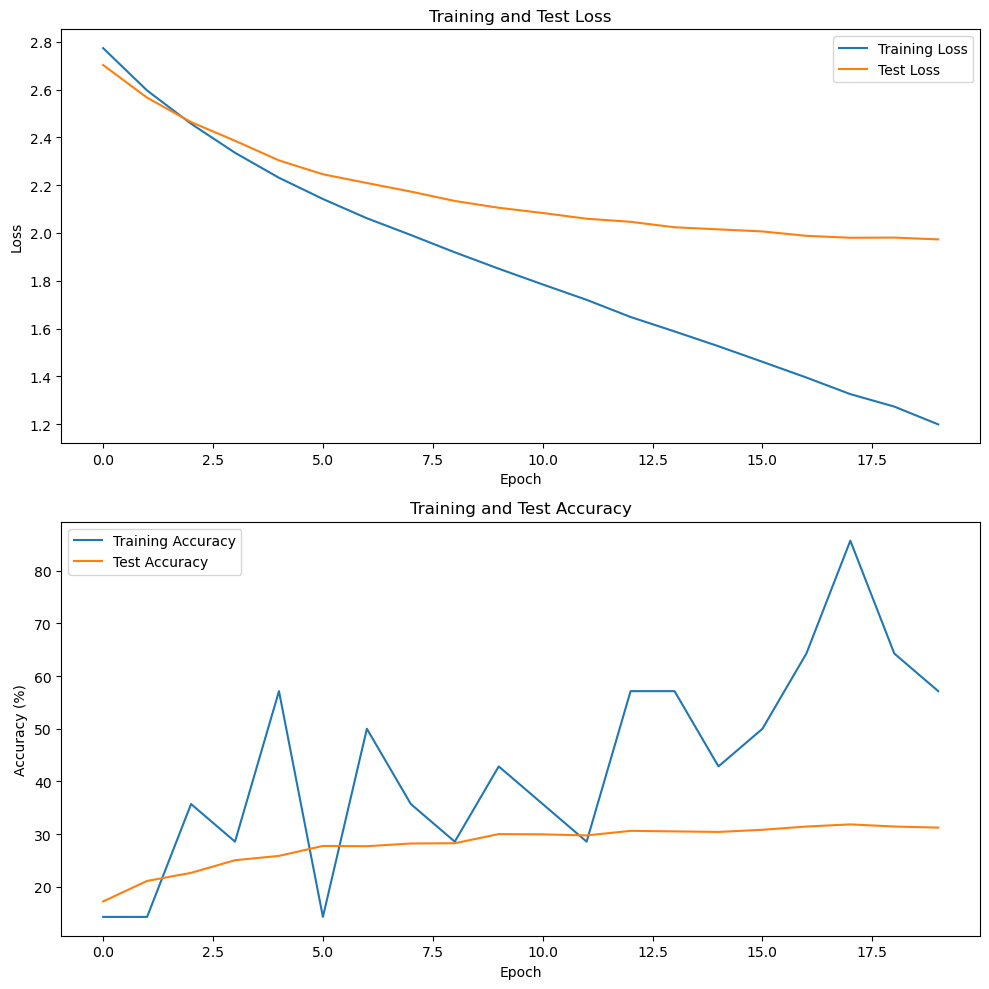

In [20]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-1-9. resnet18 / SGD(lr=0.001, mo=0.25)

In [21]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.25)

In [22]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [23]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.8138, Accuracy: 7.14%
Test loss: 2.7616, Accuracy: 16.16%
Epoch 2, Training loss: 2.6854, Accuracy: 21.43%
Test loss: 2.6851, Accuracy: 17.74%
Epoch 3, Training loss: 2.5947, Accuracy: 0.00%
Test loss: 2.6288, Accuracy: 19.68%
Epoch 4, Training loss: 2.5119, Accuracy: 7.14%
Test loss: 2.5638, Accuracy: 20.91%
Epoch 5, Training loss: 2.4325, Accuracy: 21.43%
Test loss: 2.5124, Accuracy: 20.91%
Epoch 6, Training loss: 2.3579, Accuracy: 7.14%
Test loss: 2.4648, Accuracy: 23.36%
Epoch 7, Training loss: 2.2822, Accuracy: 14.29%
Test loss: 2.4108, Accuracy: 23.93%
Epoch 8, Training loss: 2.2147, Accuracy: 28.57%
Test loss: 2.3570, Accuracy: 24.49%
Epoch 9, Training loss: 2.1435, Accuracy: 50.00%
Test loss: 2.3117, Accuracy: 25.61%
Epoch 10, Training loss: 2.0838, Accuracy: 35.71%
Test loss: 2.2803, Accuracy: 27.45%
Epoch 11, Training loss: 2.0289, Accuracy: 42.86%
Test loss: 2.2571, Accuracy: 26.79%
Epoch 12, Training loss: 1.9796, Accuracy: 42.86%
Test loss: 2.2237

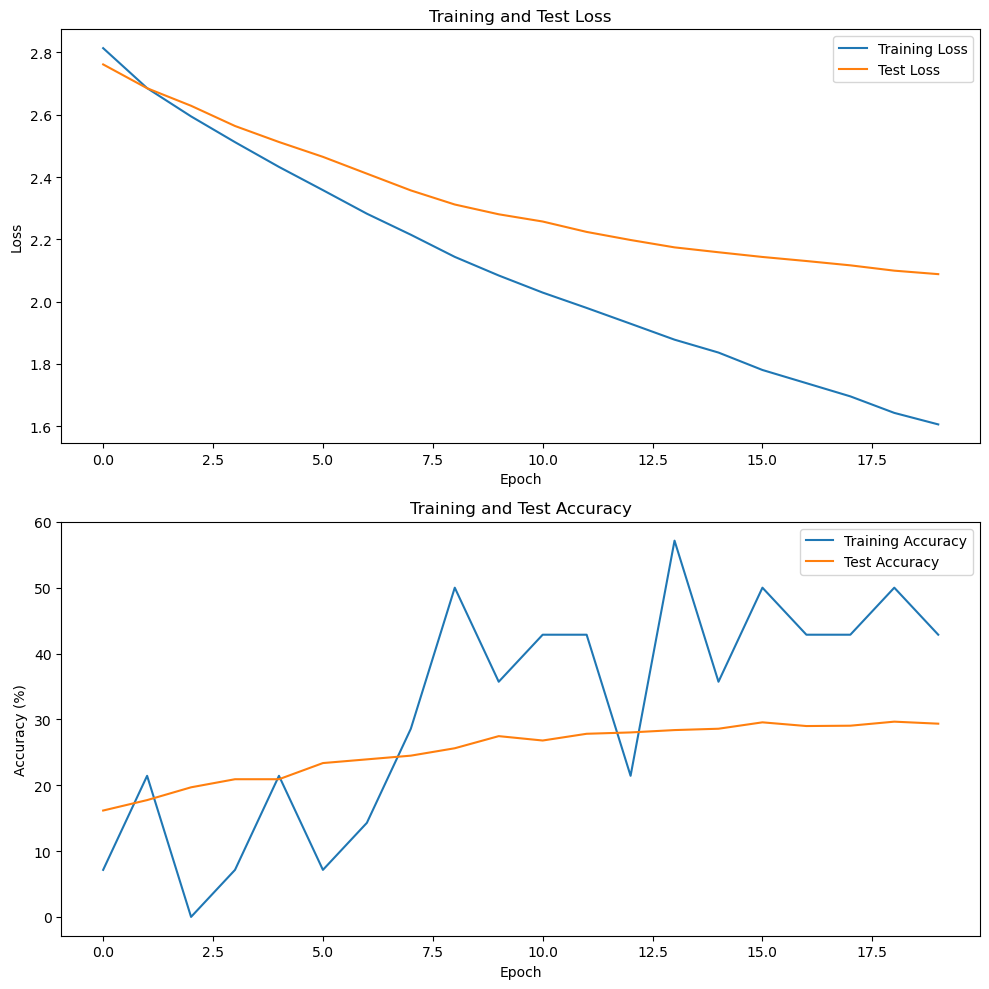

In [24]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-1. resnet18 / RMSprop(lr=0.010, mo=0.9)

In [25]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.9)

In [26]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [27]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 4.3381, Accuracy: 14.29%
Test loss: 2.9039, Accuracy: 16.10%
Epoch 2, Training loss: 2.6528, Accuracy: 21.43%
Test loss: 2.6094, Accuracy: 19.58%
Epoch 3, Training loss: 2.4195, Accuracy: 35.71%
Test loss: 2.3213, Accuracy: 23.67%
Epoch 4, Training loss: 2.2156, Accuracy: 0.00%
Test loss: 2.1464, Accuracy: 27.04%
Epoch 5, Training loss: 2.0999, Accuracy: 21.43%
Test loss: 2.1523, Accuracy: 26.33%
Epoch 6, Training loss: 2.0322, Accuracy: 14.29%
Test loss: 2.1489, Accuracy: 26.74%
Epoch 7, Training loss: 2.0335, Accuracy: 7.14%
Test loss: 2.1309, Accuracy: 28.17%
Epoch 8, Training loss: 1.8936, Accuracy: 21.43%
Test loss: 2.0491, Accuracy: 27.66%
Epoch 9, Training loss: 1.8964, Accuracy: 57.14%
Test loss: 2.1081, Accuracy: 31.34%
Epoch 10, Training loss: 1.8160, Accuracy: 21.43%
Test loss: 2.1515, Accuracy: 25.97%
Epoch 11, Training loss: 1.7715, Accuracy: 28.57%
Test loss: 2.1726, Accuracy: 28.07%
Epoch 12, Training loss: 1.7550, Accuracy: 21.43%
Test loss: 1.88

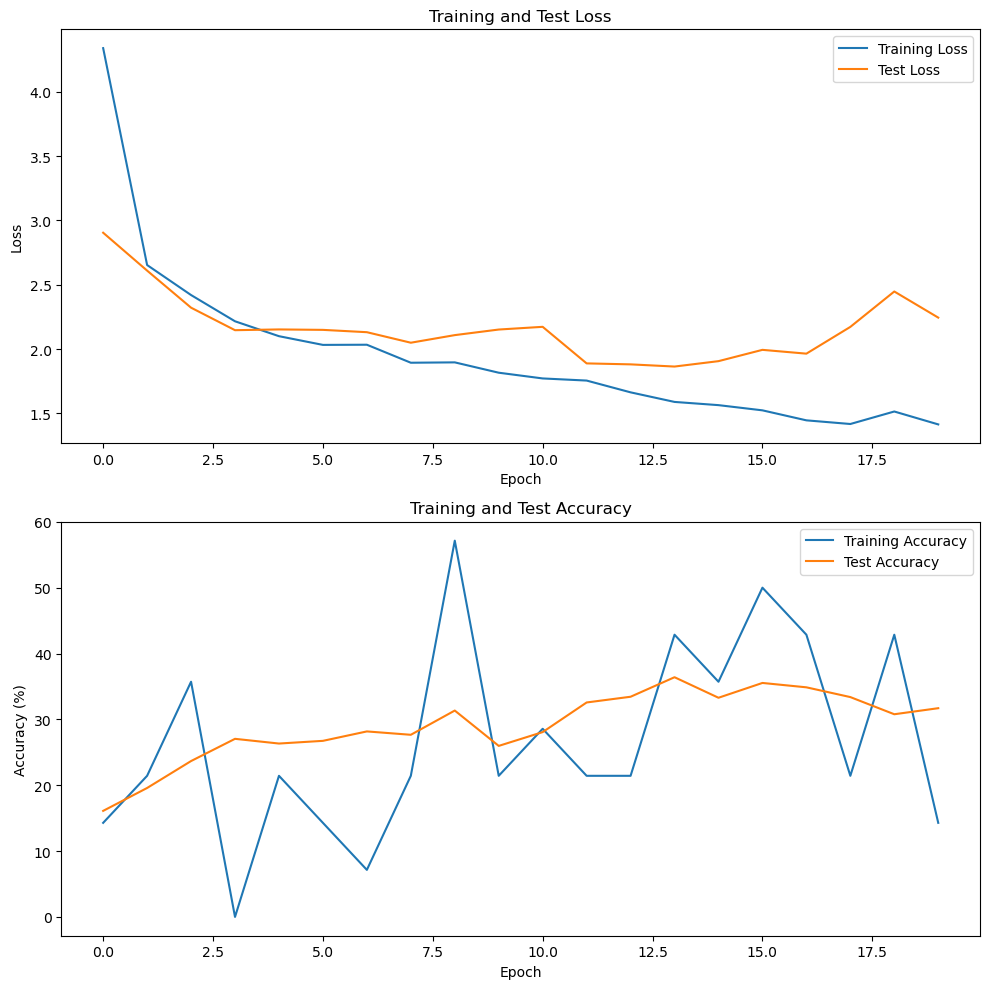

In [28]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-2. resnet18 / RMSprop(lr=0.010, mo=0.5)

In [29]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.5)

In [30]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [31]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.7659, Accuracy: 14.29%
Test loss: 2.6814, Accuracy: 15.59%
Epoch 2, Training loss: 2.4843, Accuracy: 21.43%
Test loss: 5.0576, Accuracy: 16.31%
Epoch 3, Training loss: 2.2460, Accuracy: 35.71%
Test loss: 2.3620, Accuracy: 24.13%
Epoch 4, Training loss: 2.1010, Accuracy: 7.14%
Test loss: 41.0992, Accuracy: 9.92%
Epoch 5, Training loss: 2.0131, Accuracy: 50.00%
Test loss: 2.7954, Accuracy: 21.68%
Epoch 6, Training loss: 1.9087, Accuracy: 35.71%
Test loss: 2.2246, Accuracy: 24.34%
Epoch 7, Training loss: 1.8140, Accuracy: 50.00%
Test loss: 1.9814, Accuracy: 31.19%
Epoch 8, Training loss: 1.7246, Accuracy: 57.14%
Test loss: 2.1674, Accuracy: 29.65%
Epoch 9, Training loss: 1.6378, Accuracy: 42.86%
Test loss: 1.9488, Accuracy: 30.01%
Epoch 10, Training loss: 1.5530, Accuracy: 35.71%
Test loss: 2.0248, Accuracy: 32.21%
Epoch 11, Training loss: 1.4773, Accuracy: 35.71%
Test loss: 1.9445, Accuracy: 31.44%
Epoch 12, Training loss: 1.3804, Accuracy: 57.14%
Test loss: 1.9

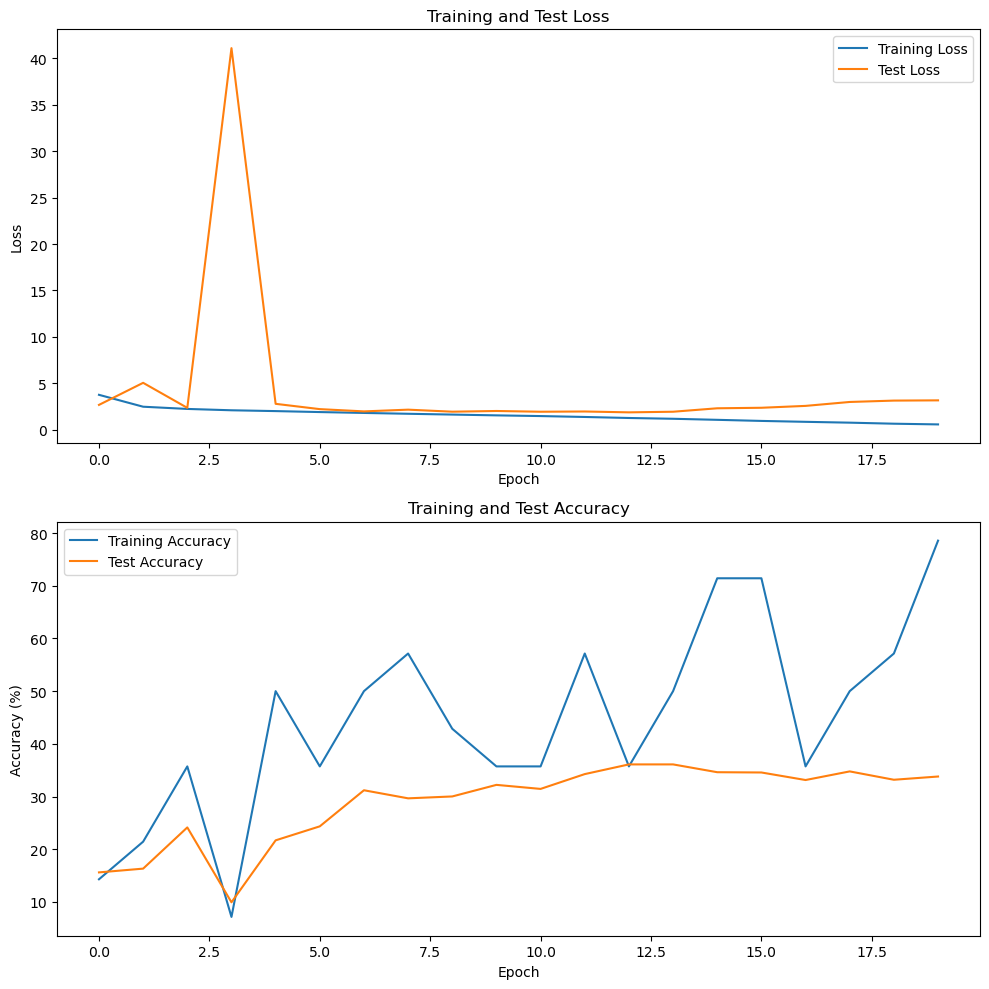

In [32]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-3. resnet18 / RMSprop(lr=0.010, mo=0.25)

In [33]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.010, momentum=0.25)

In [34]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [35]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.3632, Accuracy: 0.00%
Test loss: 2.7769, Accuracy: 12.88%
Epoch 2, Training loss: 2.5509, Accuracy: 28.57%
Test loss: 2.4795, Accuracy: 20.86%
Epoch 3, Training loss: 2.3238, Accuracy: 57.14%
Test loss: 2.3969, Accuracy: 22.09%
Epoch 4, Training loss: 2.1280, Accuracy: 14.29%
Test loss: 2.3070, Accuracy: 21.17%
Epoch 5, Training loss: 2.0017, Accuracy: 14.29%
Test loss: 2.2323, Accuracy: 25.72%
Epoch 6, Training loss: 1.8964, Accuracy: 35.71%
Test loss: 2.4635, Accuracy: 29.96%
Epoch 7, Training loss: 1.8036, Accuracy: 21.43%
Test loss: 2.6236, Accuracy: 23.98%
Epoch 8, Training loss: 1.7290, Accuracy: 21.43%
Test loss: 1.9180, Accuracy: 31.70%
Epoch 9, Training loss: 1.6415, Accuracy: 21.43%
Test loss: 1.9601, Accuracy: 34.36%
Epoch 10, Training loss: 1.5641, Accuracy: 35.71%
Test loss: 1.8751, Accuracy: 36.30%
Epoch 11, Training loss: 1.4802, Accuracy: 28.57%
Test loss: 3.0270, Accuracy: 29.70%
Epoch 12, Training loss: 1.3969, Accuracy: 42.86%
Test loss: 1.9

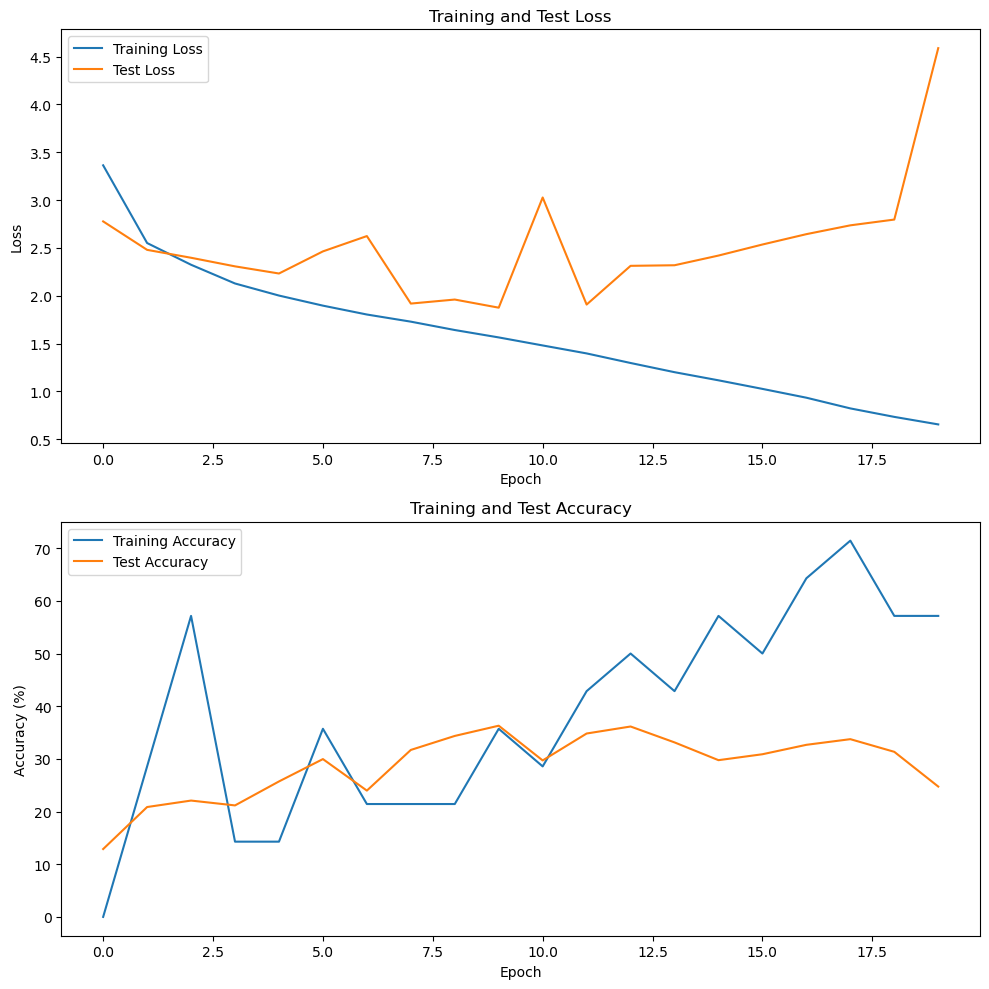

In [36]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-4. resnet18 / RMSprop(lr=0.005, mo=0.9)

In [37]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.9)

In [38]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [39]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.3555, Accuracy: 7.14%
Test loss: 2.8285, Accuracy: 10.94%
Epoch 2, Training loss: 2.7874, Accuracy: 28.57%
Test loss: 2.7446, Accuracy: 13.39%
Epoch 3, Training loss: 2.6117, Accuracy: 7.14%
Test loss: 2.4486, Accuracy: 18.71%
Epoch 4, Training loss: 2.3545, Accuracy: 14.29%
Test loss: 2.3651, Accuracy: 20.65%
Epoch 5, Training loss: 2.2439, Accuracy: 28.57%
Test loss: 2.2265, Accuracy: 20.81%
Epoch 6, Training loss: 2.1598, Accuracy: 28.57%
Test loss: 2.2691, Accuracy: 26.64%
Epoch 7, Training loss: 2.0151, Accuracy: 21.43%
Test loss: 2.1529, Accuracy: 26.69%
Epoch 8, Training loss: 1.9188, Accuracy: 21.43%
Test loss: 2.0838, Accuracy: 28.32%
Epoch 9, Training loss: 1.8171, Accuracy: 28.57%
Test loss: 1.9357, Accuracy: 30.21%
Epoch 10, Training loss: 1.7391, Accuracy: 35.71%
Test loss: 1.8332, Accuracy: 33.44%
Epoch 11, Training loss: 1.6693, Accuracy: 7.14%
Test loss: 1.8717, Accuracy: 34.25%
Epoch 12, Training loss: 1.6207, Accuracy: 50.00%
Test loss: 1.861

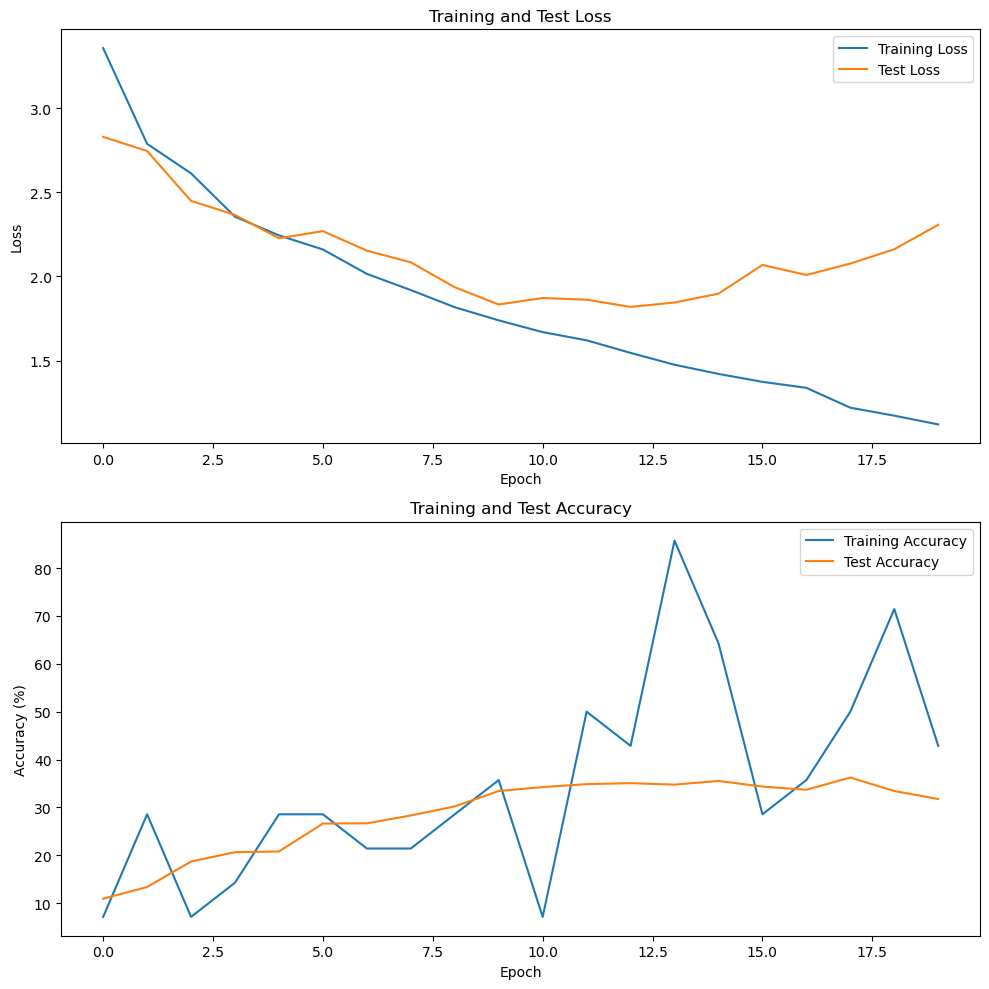

In [40]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-5. resnet18 / RMSprop(lr=0.005, mo=0.5)

In [41]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.5)

In [42]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [43]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.0975, Accuracy: 28.57%
Test loss: 2.6536, Accuracy: 17.48%
Epoch 2, Training loss: 2.2890, Accuracy: 42.86%
Test loss: 2.3489, Accuracy: 26.53%
Epoch 3, Training loss: 2.0681, Accuracy: 35.71%
Test loss: 2.0312, Accuracy: 30.21%
Epoch 4, Training loss: 1.9427, Accuracy: 35.71%
Test loss: 2.1916, Accuracy: 25.72%
Epoch 5, Training loss: 1.8456, Accuracy: 21.43%
Test loss: 2.1236, Accuracy: 27.45%
Epoch 6, Training loss: 1.7484, Accuracy: 14.29%
Test loss: 2.1256, Accuracy: 23.77%
Epoch 7, Training loss: 1.6663, Accuracy: 50.00%
Test loss: 1.9007, Accuracy: 34.87%
Epoch 8, Training loss: 1.5724, Accuracy: 21.43%
Test loss: 1.9657, Accuracy: 34.10%
Epoch 9, Training loss: 1.4913, Accuracy: 35.71%
Test loss: 2.0343, Accuracy: 30.52%
Epoch 10, Training loss: 1.3996, Accuracy: 50.00%
Test loss: 1.8112, Accuracy: 36.30%
Epoch 11, Training loss: 1.2882, Accuracy: 50.00%
Test loss: 1.8445, Accuracy: 36.76%
Epoch 12, Training loss: 1.1869, Accuracy: 50.00%
Test loss: 2.

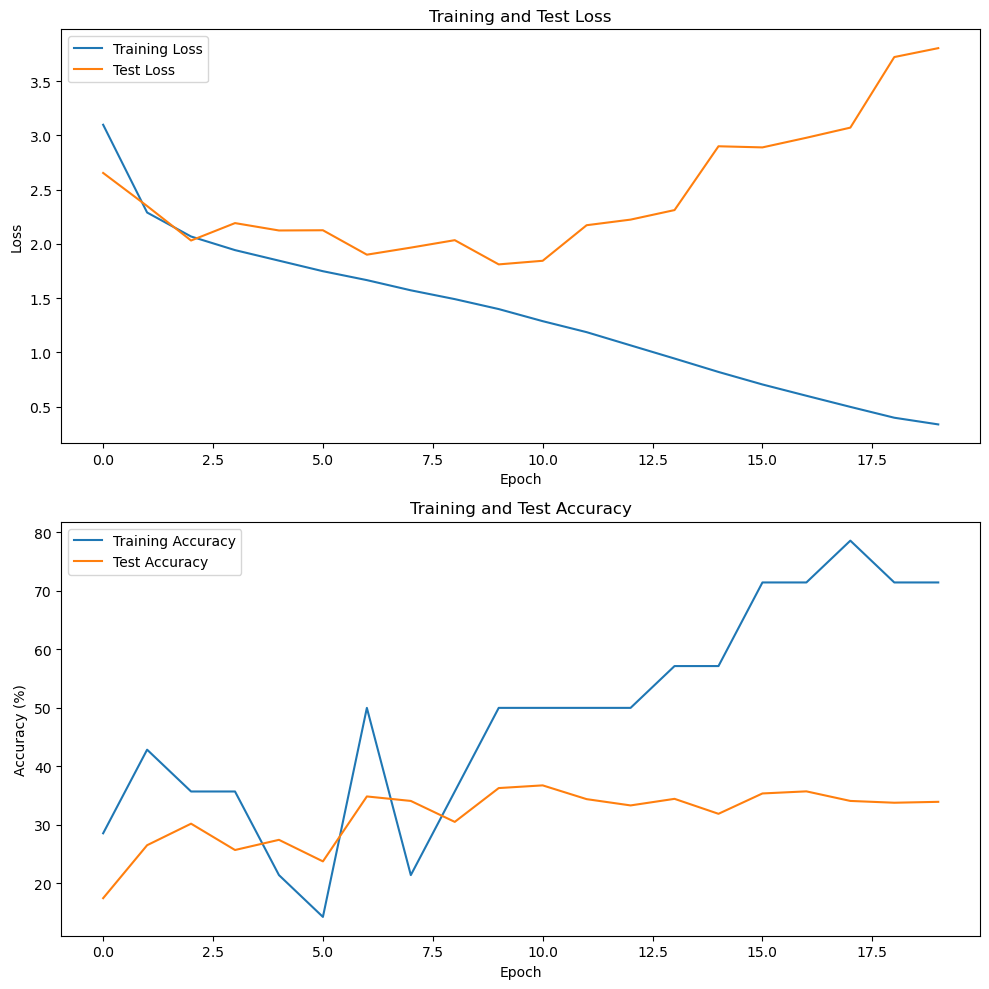

In [44]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-6. resnet18 / RMSprop(lr=0.005, mo=0.25)

In [45]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.005, momentum=0.25)

In [46]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [47]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.1070, Accuracy: 28.57%
Test loss: 3.1202, Accuracy: 10.74%
Epoch 2, Training loss: 2.3179, Accuracy: 14.29%
Test loss: 2.8346, Accuracy: 14.98%
Epoch 3, Training loss: 2.0956, Accuracy: 28.57%
Test loss: 2.2146, Accuracy: 25.10%
Epoch 4, Training loss: 1.9405, Accuracy: 7.14%
Test loss: 2.2776, Accuracy: 25.31%
Epoch 5, Training loss: 1.8315, Accuracy: 35.71%
Test loss: 2.3461, Accuracy: 20.35%
Epoch 6, Training loss: 1.7321, Accuracy: 21.43%
Test loss: 2.2126, Accuracy: 22.85%
Epoch 7, Training loss: 1.6513, Accuracy: 50.00%
Test loss: 1.9151, Accuracy: 33.38%
Epoch 8, Training loss: 1.5346, Accuracy: 42.86%
Test loss: 1.8758, Accuracy: 33.69%
Epoch 9, Training loss: 1.4414, Accuracy: 64.29%
Test loss: 1.8053, Accuracy: 34.10%
Epoch 10, Training loss: 1.3379, Accuracy: 35.71%
Test loss: 2.3275, Accuracy: 31.03%
Epoch 11, Training loss: 1.2553, Accuracy: 50.00%
Test loss: 2.3905, Accuracy: 33.08%
Epoch 12, Training loss: 1.1243, Accuracy: 42.86%
Test loss: 2.4

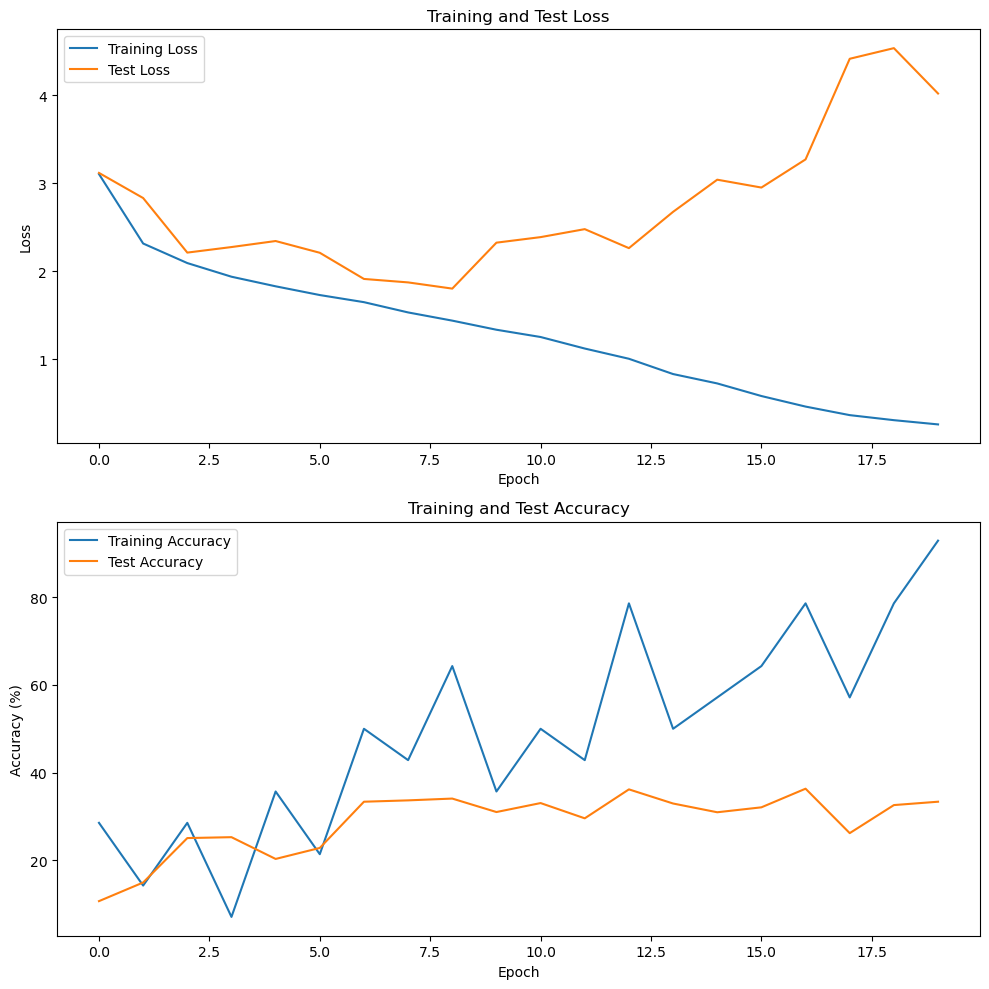

In [48]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-7. resnet18 / RMSprop(lr=0.001, mo=0.9)

In [17]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [19]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 3.1504, Accuracy: 28.57%
Test loss: 2.8163, Accuracy: 15.90%
Epoch 2, Training loss: 2.4119, Accuracy: 7.14%
Test loss: 2.2931, Accuracy: 25.20%
Epoch 3, Training loss: 2.1404, Accuracy: 35.71%
Test loss: 2.2790, Accuracy: 26.94%
Epoch 4, Training loss: 2.0043, Accuracy: 42.86%
Test loss: 2.0624, Accuracy: 31.44%
Epoch 5, Training loss: 1.8940, Accuracy: 35.71%
Test loss: 2.3394, Accuracy: 30.32%
Epoch 6, Training loss: 1.8001, Accuracy: 21.43%
Test loss: 2.2381, Accuracy: 29.55%
Epoch 7, Training loss: 1.7190, Accuracy: 50.00%
Test loss: 4.3390, Accuracy: 32.52%
Epoch 8, Training loss: 1.6402, Accuracy: 35.71%
Test loss: 1.8868, Accuracy: 34.36%
Epoch 9, Training loss: 1.5650, Accuracy: 21.43%
Test loss: 1.9777, Accuracy: 36.81%
Epoch 10, Training loss: 1.4906, Accuracy: 35.71%
Test loss: 2.1290, Accuracy: 35.99%
Epoch 11, Training loss: 1.3922, Accuracy: 42.86%
Test loss: 1.9771, Accuracy: 35.48%
Epoch 12, Training loss: 1.3035, Accuracy: 21.43%
Test loss: 1.9

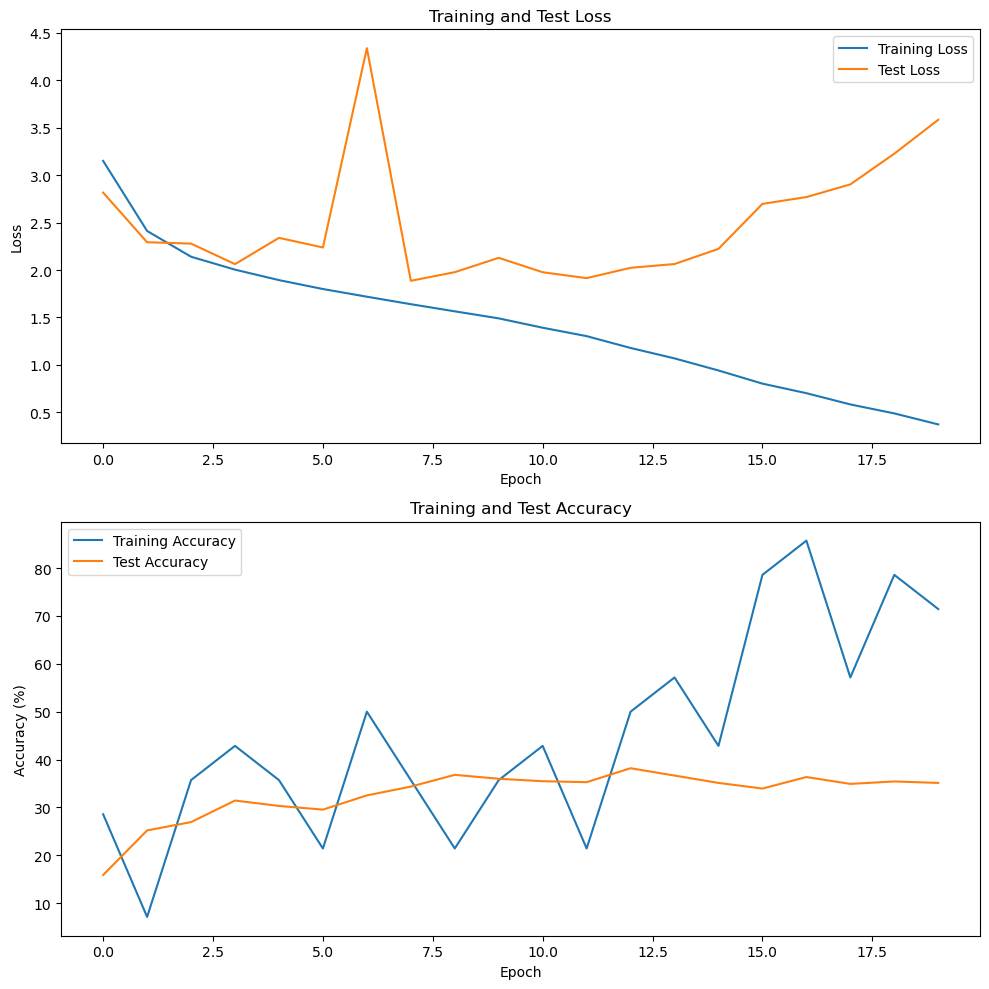

In [20]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-8. resnet18 / RMSprop(lr=0.001, mo=0.5)

In [21]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.5)

In [22]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [23]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.6612, Accuracy: 7.14%
Test loss: 2.3256, Accuracy: 24.13%
Epoch 2, Training loss: 2.0721, Accuracy: 14.29%
Test loss: 2.1710, Accuracy: 25.31%
Epoch 3, Training loss: 1.8913, Accuracy: 35.71%
Test loss: 3.0066, Accuracy: 19.38%
Epoch 4, Training loss: 1.7688, Accuracy: 21.43%
Test loss: 2.0671, Accuracy: 27.15%
Epoch 5, Training loss: 1.6647, Accuracy: 35.71%
Test loss: 2.0404, Accuracy: 30.83%
Epoch 6, Training loss: 1.5539, Accuracy: 28.57%
Test loss: 1.8986, Accuracy: 33.95%
Epoch 7, Training loss: 1.4378, Accuracy: 42.86%
Test loss: 1.9571, Accuracy: 31.60%
Epoch 8, Training loss: 1.3196, Accuracy: 71.43%
Test loss: 1.9245, Accuracy: 37.17%
Epoch 9, Training loss: 1.1945, Accuracy: 50.00%
Test loss: 1.9065, Accuracy: 36.15%
Epoch 10, Training loss: 1.0508, Accuracy: 42.86%
Test loss: 2.2616, Accuracy: 33.13%
Epoch 11, Training loss: 0.9156, Accuracy: 57.14%
Test loss: 2.6700, Accuracy: 31.44%
Epoch 12, Training loss: 0.7363, Accuracy: 71.43%
Test loss: 2.6

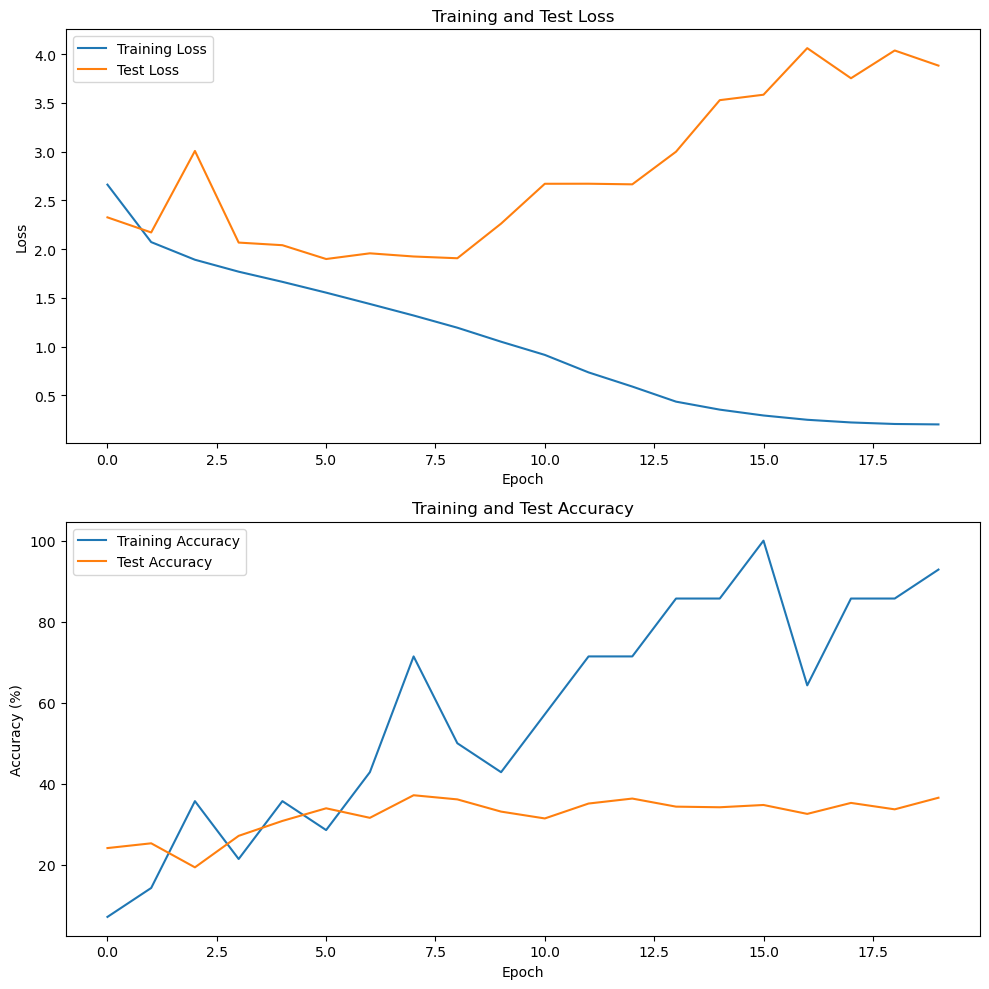

In [24]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)

### 1-2-9. resnet18 / RMSprop(lr=0.001, mo=0.25)

In [25]:
model = myResNet(18, num_classes=18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.25)

In [26]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [27]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 2.5644, Accuracy: 14.29%
Test loss: 2.4801, Accuracy: 19.73%
Epoch 2, Training loss: 2.0357, Accuracy: 57.14%
Test loss: 7.2650, Accuracy: 20.45%
Epoch 3, Training loss: 1.8773, Accuracy: 50.00%
Test loss: 2.0686, Accuracy: 28.27%
Epoch 4, Training loss: 1.7343, Accuracy: 21.43%
Test loss: 2.0762, Accuracy: 25.72%
Epoch 5, Training loss: 1.6111, Accuracy: 28.57%
Test loss: 1.9686, Accuracy: 32.16%
Epoch 6, Training loss: 1.5152, Accuracy: 50.00%
Test loss: 1.8695, Accuracy: 34.71%
Epoch 7, Training loss: 1.4012, Accuracy: 42.86%
Test loss: 2.0596, Accuracy: 32.46%
Epoch 8, Training loss: 1.2761, Accuracy: 28.57%
Test loss: 3.7752, Accuracy: 29.55%
Epoch 9, Training loss: 1.1667, Accuracy: 71.43%
Test loss: 2.4854, Accuracy: 32.72%
Epoch 10, Training loss: 1.0244, Accuracy: 42.86%
Test loss: 2.5896, Accuracy: 30.27%
Epoch 11, Training loss: 0.8751, Accuracy: 71.43%
Test loss: 2.4319, Accuracy: 34.51%
Epoch 12, Training loss: 0.7195, Accuracy: 57.14%
Test loss: 2.

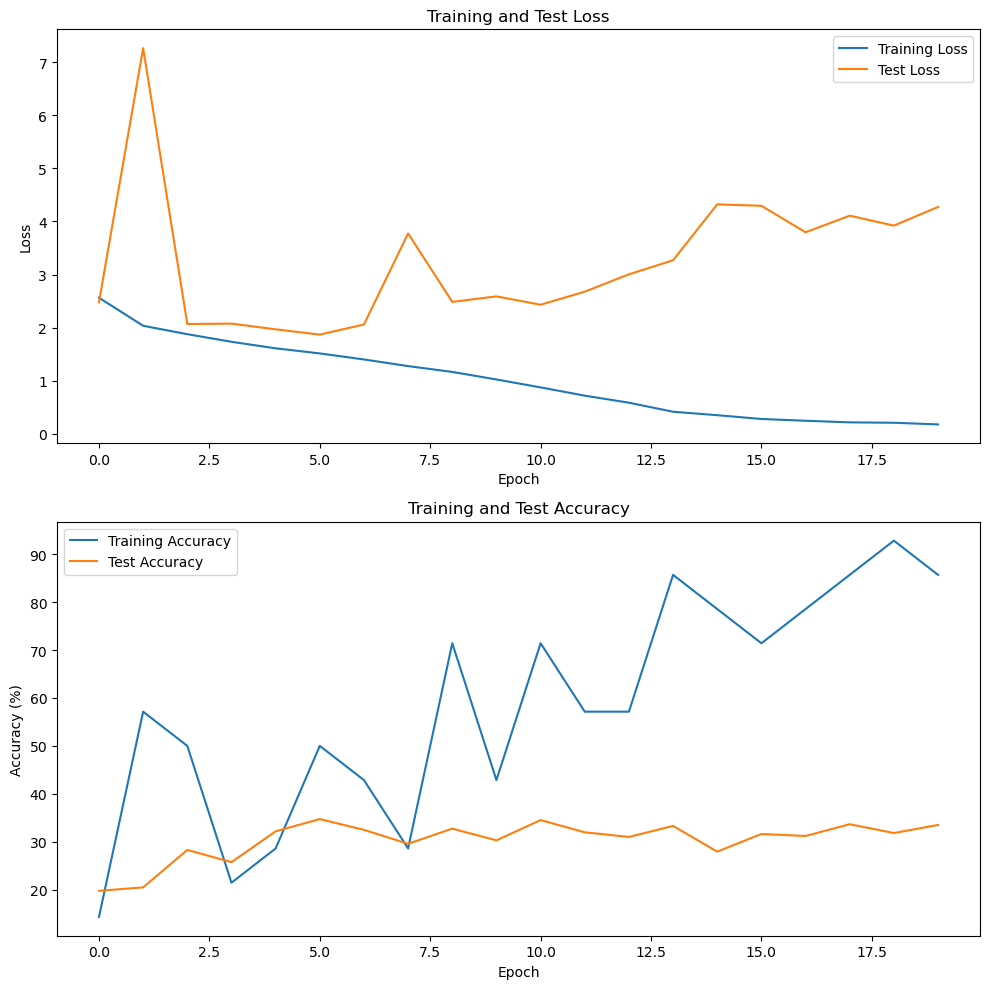

In [28]:
val_plot(train_losses, test_losses, train_accuracies, test_accuracies)